In [271]:
import os
import re
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import json
import folium
import matplotlib
import matplotlib.pyplot as plt
import geopy
%matplotlib inline

from IPython.core.display import display, HTML

# Turn slice copy warnings off
pd.options.mode.chained_assignment = None

import findspark
findspark.init()
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, FloatType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

### Education

In this section, we will be examining education within NYC and seeing how it varies between different parts of the city. For our two main metrics, we chose Graduation % and Dropout % rates as both are widely accepted as strong indicators of education quality. We begin by mapping these two metrics according to NYC boroughs and, then, go on to map them to NYC postcodes - an increase in the mapping specificity. 

Finally, we go on to create a singular metric representative of both Graduation % and Dropout % in order to make it possible for readers to more easily compare different areas within NYC according to education.

In [272]:
data_folder = './data/'

In [273]:
ed_boroughs = pd.ExcelFile(data_folder + '2017-graduation_rates_public_borough.xlsx')
ed_sheet_names = ed_boroughs.sheet_names

In [274]:
ed_sheets = {}

for name in ed_sheet_names:
    df = ed_boroughs.parse(name, skiprows=list(range(7))) 
    ed_sheets[name] = df
df_all_students = ed_sheets[ed_sheet_names[1]]
    
# Show all of the columns
print(list(df_all_students))

# Show a few rows from the data
df_all_students.head(3)

['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Cohort', 'Total Grads', 'Unnamed: 6', 'Total Regents', 'Unnamed: 8', 'Unnamed: 9', 'Advanced Regents', 'Unnamed: 11', 'Unnamed: 12', 'Regents without Advanced', 'Unnamed: 14', 'Unnamed: 15', 'Local', 'Unnamed: 17', 'Unnamed: 18', 'Still Enrolled', 'Unnamed: 20', 'Dropout', 'Unnamed: 22', 'SACC (IEP Diploma)', 'Unnamed: 24', 'TASC (GED)', 'Unnamed: 26']


Unnamed: 0    Unnamed: 1   Unnamed: 2     Unnamed: 3 Cohort Total Grads  \
0    Borough      Category  Cohort Year         Cohort      #           #   
1      Bronx  All Students         2013  4 year August  13730        9102   
2      Bronx  All Students         2012  4 year August  13838        8985   

    Unnamed: 6 Total Regents   Unnamed: 8  Unnamed: 9     ...       \
0  % of cohort             #  % of cohort  % of grads     ...        
1      66.2928          8105      59.0313     89.0464     ...        
2      64.9299          8149      58.8886     90.6956     ...        

   Unnamed: 17 Unnamed: 18 Still Enrolled  Unnamed: 20 Dropout  Unnamed: 22  \
0  % of cohort  % of grads              #  % of cohort       #  % of cohort   
1      7.26147     10.9536           2742      19.9709    1606       11.697   
2      6.04134      9.3044           2876      20.7833    1757      12.6969   

  SACC (IEP Diploma)  Unnamed: 24 TASC (GED)  Unnamed: 26  
0                  #  % of cohort          #  % of cohort  
1                118     0.859432        151      1.09978  
2                100     0.722648        110     0.794913  

[3 rows x 27 columns]

We can see that, due to overlap in naming conventions as well as slightly incompatible header formatting, the column names are not very clear and the first row is simply sub-headers.  

To clean the data up, we will remove the unecessary columns and rename the remaining columns to be more readable.  
We care primarily about the raw numbers of Total Grads as well as Dropouts so we will drop the irrelevant columns.

In [275]:
df_grads_dropouts = df_all_students[['Unnamed: 0', 'Unnamed: 2', 'Cohort', 'Total Grads', 'Unnamed: 6', 'Dropout', 'Unnamed: 22']]
df_grads_dropouts.rename(columns={'Unnamed: 0': 'Borough', 'Unnamed: 2': 'Year','Unnamed: 6': 'Total Grads %', 'Unnamed: 22': 'Dropout %'}, inplace=True)
df_grads_dropouts.drop(0, inplace=True)
df_grads_dropouts.head()

Borough  Year Cohort Total Grads Total Grads % Dropout Dropout %
1   Bronx  2013  13730        9102       66.2928    1606    11.697
2   Bronx  2012  13838        8985       64.9299    1757   12.6969
3   Bronx  2011  14278        8821       61.7804    1866   13.0691
4   Bronx  2010  14229        8405       59.0695    2013   14.1472
5   Bronx  2009  15149        8712       57.5087    2336   15.4201

Immediately, there are some things to note about the data:
- There are duplicate rows for each year. This is due to each year having cohorts that start at different times. We will use the 4 year August cohort from 2013 for our purposes.
- Graduation is defined as receiving either a Regent or Local diploma from a NYC highschool - a Local diploma being easier to achieve but functionally very similar. We will be ignoring the distinction in our analysis.
- The Total Grads % and Dropout % do not add up to 100%. This is because some students continue high school past the standard graduation date (e.g. in order to makeup for missing coursework).

Next, let us create maps to make the rates of graduation and dropout more visually apparent:

In [276]:
# We will pick the latest year available, 2013, for use here.

# Filtering by year 2013
df_2013 = df_grads_dropouts[df_grads_dropouts['Year'] == 2013].reset_index(drop=True)

# Selecting the 4 year August cohort
df_2013 = df_2013.iloc[::2].reset_index(drop=True)

In [277]:
# Mapping graduation rates (%)
grads_map = folium.Map(location=[40.75, -74],
                       tiles='cartodbpositron',
                       zoom_start=11)

borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))

folium.GeoJson(
    borough_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough'], aliases=['Borough'], labels=True, sticky=True)
).add_to(grads_map)

folium.Choropleth(
    geo_data=borough_edge, 
    data=df_2013,
    columns=['Borough', 'Total Grads %'],
    nan_fill_color='grey',
    bins=9,
    key_on = 'feature.properties.borough',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3, line_color='black',
    legend_name='Graduation Percentage in NYC Boroughs, 4 Year Class of August 2013',
    highlight=True).add_to(grads_map)

grads_map

In [278]:
# Mapping dropout rates (%)
drops_map = folium.Map(location=[40.75, -74],
                       tiles='cartodbpositron',
                       zoom_start=11)

borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))

folium.GeoJson(
    borough_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough'], aliases=['Borough'], labels=True, sticky=True)
).add_to(drops_map)

folium.Choropleth(
    geo_data=borough_edge, 
    data=df_2013,
    columns=['Borough', 'Dropout %'],
    nan_fill_color='grey',
    bins=9,
    key_on = 'feature.properties.borough',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3, line_color='black',
    legend_name='Dropout Percentage in NYC Boroughs, 4 Year Class of August 2013',
    highlight=True).add_to(drops_map)

drops_map

We can see that, as is expected, the graduation rates are much higher in the wealthy parts of NYC (i.e. Manhattan and Queens) than the other boroughs.  
Furthermore, the dropout rate is much higher in the Bronx, generally a poorer NYC borough.

Next, we will follow a similar line of examination but on a per-postcode basis:  
Here, we simply prepare the data necessary to map schools to postcodes.

In [279]:
school_data_xls = pd.ExcelFile(data_folder + '2017-graduation_rates_public_school.xlsx')
school_data_sheet_names = school_data_xls.sheet_names

In [280]:
school_sheets = {}

for name in school_data_sheet_names:
    df = school_data_xls.parse(name, skiprows=list(range(7))) 
    school_sheets[name] = df
df_all_schools = school_sheets[school_data_sheet_names[1]]

In [281]:
# Select only the columns we need
df_all_schools.rename(columns={'Unnamed: 0': 'DBN', 'Unnamed: 1': 'Name', 'Unnamed: 3': 'Year', 'Unnamed: 4': 'Cohort_Type', 'Unnamed: 7': 'Total Grads %', 'Unnamed: 23': 'Dropout %'}, inplace=True)
df_sch = df_all_schools[['DBN', 'Name', 'Year', 'Total Grads %', 'Dropout %']]
df_sch.drop(0, inplace=True)
df_sch.head()

DBN                        Name  Year Total Grads % Dropout %
1  01M292  ORCHARD COLLEGIATE ACADEMY  2013       69.4444   19.4444
2  01M292  ORCHARD COLLEGIATE ACADEMY  2012       54.5455   22.7273
3  01M292  ORCHARD COLLEGIATE ACADEMY  2011       63.0137   9.58904
4  01M292  ORCHARD COLLEGIATE ACADEMY  2010        42.623   27.8688
5  01M292  ORCHARD COLLEGIATE ACADEMY  2009       57.6471   9.41176

In [282]:
# Simply removing useless entries

df_sch['Total Grads %'] = pd.to_numeric(df_sch['Total Grads %'], errors='coerce')
df_sch['Dropout %'] = pd.to_numeric(df_sch['Dropout %'], errors='coerce')
df_sch.dropna(inplace=True)

# Select 2013
df_2013_post = df_sch[df_sch['Year'] == 2013]
print(df_2013_post.dtypes)
df_2013_post.head()

DBN               object
Name              object
Year              object
Total Grads %    float64
Dropout %        float64
dtype: object


DBN                                 Name  Year  Total Grads %  \
1   01M292           ORCHARD COLLEGIATE ACADEMY  2013       69.44444   
10  01M292           ORCHARD COLLEGIATE ACADEMY  2013       66.66666   
47  01M448  UNIVERSITY NEIGHBORHOOD HIGH SCHOOL  2013       89.74358   
56  01M448  UNIVERSITY NEIGHBORHOOD HIGH SCHOOL  2013       89.74358   
99  01M450           EAST SIDE COMMUNITY SCHOOL  2013       91.01123   

    Dropout %  
1   19.444440  
10  19.444440  
47   8.974358  
56   8.974358  
99   3.370786

In [283]:
# Now, we group the resulting dataframe by school names and average the percentages
df_2013_grouped = df_2013_post.groupby(['DBN', 'Name']).mean()
df_2013_grouped.head()

Total Grads %  Dropout %
DBN    Name                                                         
01M292 ORCHARD COLLEGIATE ACADEMY               68.055550  19.444440
01M448 UNIVERSITY NEIGHBORHOOD HIGH SCHOOL      89.743580   8.974358
01M450 EAST SIDE COMMUNITY SCHOOL               90.449435   3.370786
01M458 FORSYTH SATELLITE ACADEMY                15.425525  12.765950
01M509 MARTA VALLE HIGH SCHOOL                  69.491520   6.779661

### Education at the Postcode Level

In [284]:
addr_folder = './data/school_addr/'

In [285]:
school_addr = pd.read_csv(addr_folder + '2016-doe-high-school-directory.csv')

In [286]:
school_pos = school_addr[['dbn', 'Postcode']]
school_pos.rename(columns={'dbn': 'DBN'}, inplace=True) # for consistency
school_pos.dropna(inplace=True)
school_pos.head()

school_pos.describe()

# Here, we've found positions for most schools in NYC. 

Postcode
count    437.000000
mean   10723.951945
std      537.785205
min    10001.000000
25%    10301.000000
50%    10469.000000
75%    11217.000000
max    11694.000000

In [287]:
# Printing entry with the lowest graduation rate
df_2013_grouped.loc[df_2013_grouped['Total Grads %'].idxmin()]

Total Grads %      0.0
Dropout %        100.0
Name: (12X278, PEACE AND DIVERSITY ACADEMY), dtype: float64

As we can see, there are some severe outliers and issues. The above entry, for instance, is clearly flawed (as a school cannot possibly have a 100% dropout rate).

In [288]:
# Merging the two to position our schools properly
df_merged = df_2013_grouped.merge(school_pos, on='DBN', how='outer')
df_merged.dropna(inplace=True)

# Drop rows with absurdly high dropout rates and low graduation rates
df_merged = df_merged[df_merged['Dropout %'] < 60] 
df_merged = df_merged[df_merged['Total Grads %'] > 40]

df_merged = df_merged.groupby(['Postcode']).mean().reset_index()
df_merged.head()

Postcode  Total Grads %  Dropout %
0   10002.0      85.073264   4.839013
1   10003.0      80.451124   5.241847
2   10004.0      78.858769   9.008314
3   10006.0      78.603625   6.709189
4   10009.0      90.449435   3.370786

As we do not have data on schools from every single postcode, we will add empty rows for each missing postcode so that they can later be interpolated.

In [289]:
# Adding in missing postcode values:
df_merged['Postcode'] = df_merged['Postcode'].astype(int)
postcode_edge = json.load(open(os.path.join('data', 'nyc-postcode.json')))

zipcodes = set()
for feature in postcode_edge["features"]:
    zipcodes.add(int(feature["properties"]["postalCode"]))

for code in zipcodes:
    if code not in df_merged['Postcode'].unique():
        df_merged = df_merged.append({'Postcode': int(code), 'Total Grads %': np.NaN, 'Dropout %': np.NaN}, ignore_index=True)

# Remove invalid zipcodes
df_merged = df_merged[df_merged.Postcode >= 10000]
df_merged = df_merged.sort_values(by="Postcode").reset_index(drop=True)

Due to the limitations of our data, a large amount of zipcodes are left without any education data, making it more difficult to come to conclusions.  
Note, also, that two postcodes which are physically close to each other (and, thus, have similar education properties) generally also have similar postcode numbers. 

Thus, we will simply linearly interpolate the NaN values and see if the interpolation seems fair.

In [290]:
df_merged_interp = df_merged.interpolate()
df_merged_interp.head(3)

Postcode  Total Grads %  Dropout %
0   10001.0            NaN        NaN
1   10002.0      85.073264   4.839013
2   10003.0      80.451124   5.241847

In [291]:
# Notice that the first row wasn't succesfully interpolated so we'll manually set it equal to the second row

df_merged_interp.loc[0][['Total Grads %', 'Dropout %']] = df_merged_interp.loc[1][['Total Grads %', 'Dropout %']]
df_merged_interp.head(3)

Postcode  Total Grads %  Dropout %
0   10001.0      85.073264   4.839013
1   10002.0      85.073264   4.839013
2   10003.0      80.451124   5.241847

Let us graph the original and interpolated data to compare the two and see if the chosen interpolation is fair:

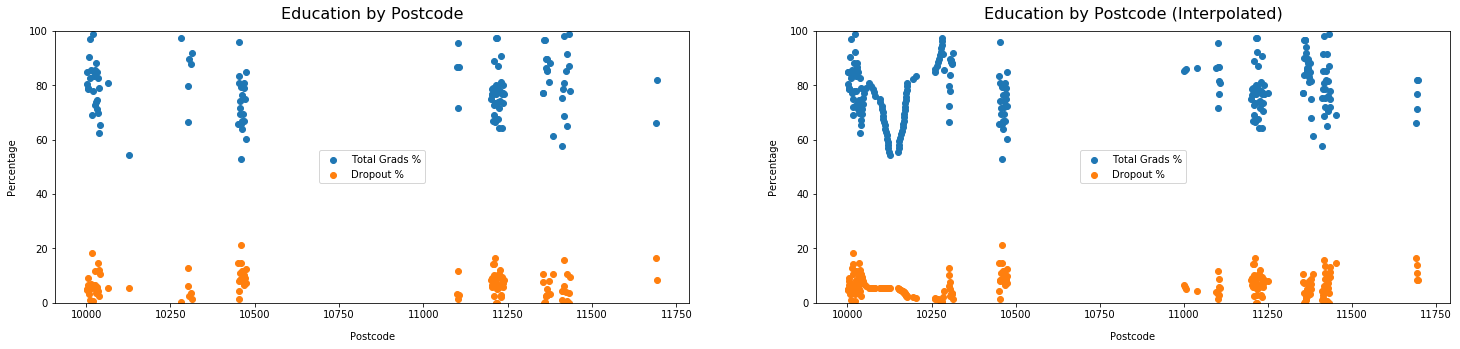

In [292]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].set_title('Education by Postcode', fontsize=16, pad=12)
axs[0].scatter(df_merged['Postcode'], df_merged['Total Grads %'])
axs[0].scatter(df_merged["Postcode"], df_merged['Dropout %'])
axs[1].set_title('Education by Postcode (Interpolated)', fontsize=16, pad=12)
axs[1].scatter(df_merged_interp['Postcode'], df_merged_interp['Total Grads %'])
axs[1].scatter(df_merged_interp["Postcode"], df_merged_interp['Dropout %'])

for ax in axs:
    ax.set_ylim(0, 100)
    ax.set_xlabel('Postcode', labelpad=12)
    ax.set_ylabel('Percentage', labelpad=12)
    ax.legend(loc='center')

We can see that the interpolation provides values well within reason. Postcodes closer to each other having more similar interpolated values - exactly what one would expect from real-world data.

Next, let us map the Graduation % and Dropout % so that we can get an intuitive feel for things:

In [293]:
# Convert postcodes to strings for compatability with the json postcodes
df_merged_interp['Postcode'] = df_merged_interp['Postcode'].astype(str).apply(lambda x: x[:-2])

In [294]:
drops = folium.Map(location=[40.75, -74],
                   tiles='cartodbpositron',
                   zoom_start=11)

folium.Choropleth(
    geo_data=postcode_edge, 
    data=df_merged_interp,
    columns=['Postcode', 'Total Grads %'],
    nan_fill_color='grey',
    bins=9,
    key_on = 'feature.properties.postalCode',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
    legend_name='Graduation Percentage by NYC Postcodes, Class of 2013',
    highlight=True
).add_to(drops)

folium.GeoJson(
    postcode_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)
).add_to(drops)

drops

In [295]:
drops = folium.Map(location=[40.75, -74],
                   tiles='cartodbpositron',
                   zoom_start=11)

folium.Choropleth(
    geo_data=postcode_edge, 
    data=df_merged_interp,
    columns=['Postcode', 'Dropout %'],
    nan_fill_color='grey',
    bins=9,
    key_on = 'feature.properties.postalCode',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
    legend_name='Dropout Percentage by NYC Postcodes, Class of 2013',
    highlight=True
).add_to(drops)

folium.GeoJson(
    postcode_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)
).add_to(drops)

drops

### Custom Metric

As seen above, we have been examining two properties of education which are both intuitively relevant to quality of education. Comparing against two metrics simultaneously, though, can be tedious for readers and, so, it makes sense to combine them into a single metric. For the sake of simplicity and transparency, we have chosen the following metric, scaled to [0, 1]:

$$\text{Score} = \log\bigg(\frac{\text{Total Grads %}}{\text{Dropout %}}\bigg)$$

In [296]:
df_merged_interp['Metric'] = df_merged_interp['Total Grads %'] / df_merged_interp['Dropout %']
df_merged_interp.head()

Postcode  Total Grads %  Dropout %     Metric
0    10001      85.073264   4.839013  17.580705
1    10002      85.073264   4.839013  17.580705
2    10003      80.451124   5.241847  15.347857
3    10004      78.858769   9.008314   8.753999
4    10005      78.731197   7.858751  10.018283

Let us print some information about this Metric column:  
*Replacing p.inf with $0$ in order to get some useful result*

In [297]:
df_merged_interp['Metric'].replace(np.inf, 0).describe()

count     246.000000
mean       34.385747
std       106.701380
min         0.000000
25%         8.723622
50%        12.744103
75%        23.080153
max      1209.854171
Name: Metric, dtype: float64

We can see that there are at least a few extreme outliers. So we will graph the metric to see them more clearly:

<function show at 0x7f9dc65deae8>

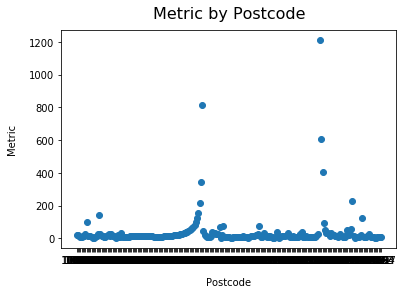

In [298]:
plt.title('Metric by Postcode', fontsize=16, pad=12)
plt.scatter(df_merged_interp['Postcode'], df_merged_interp['Metric'])
plt.xlabel('Postcode', labelpad=12)
plt.ylabel('Metric', labelpad=12)

plt.show

Quite clearly, it's worth removing the offending postcodes.

Let us remove the top 15 rows with highest metric scores:

In [299]:
for i in range(15):
    df_merged_interp.drop(df_merged_interp['Metric'].idxmax(), inplace=True)

Graphing again:

<function show at 0x7f9dc65deae8>

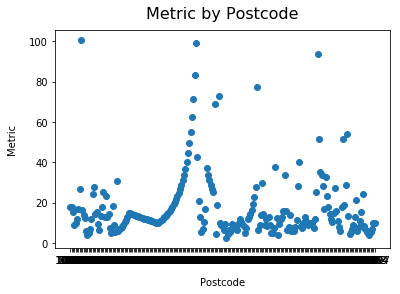

In [300]:
plt.title('Metric by Postcode', fontsize=16, pad=12)
plt.scatter(df_merged_interp['Postcode'], df_merged_interp['Metric'])
plt.xlabel('Postcode', labelpad=12)
plt.ylabel('Metric', labelpad=12)

plt.show

Already, this looks better. Now, we can scale the value to the range [0, 1].  
As there is a disproportionately large number of postcodes with small metric values, we will first take the log of the scores and then scale them

In [301]:
df_merged_interp['Metric'].describe()

count    231.000000
mean      17.728172
std       16.465917
min        2.497091
25%        8.733748
50%       12.549985
75%       18.917662
max      100.510008
Name: Metric, dtype: float64

In [302]:
df_merged_interp['Normalized'] = np.log(df_merged_interp['Metric'])
df_merged_interp['Normalized'] = df_merged_interp['Normalized'] - df_merged_interp['Normalized'].min()
df_merged_interp['Normalized'] = df_merged_interp['Normalized'] / df_merged_interp['Normalized'].max()

In [303]:
df_merged_interp.head()

Postcode  Total Grads %  Dropout %     Metric  Normalized
0    10001      85.073264   4.839013  17.580705    0.528175
1    10002      85.073264   4.839013  17.580705    0.528175
2    10003      80.451124   5.241847  15.347857    0.491417
3    10004      78.858769   9.008314   8.753999    0.339469
4    10005      78.731197   7.858751  10.018283    0.375977

In [304]:
df_merged_interp['Normalized'].describe()

count    231.000000
mean       0.457210
std        0.186297
min        0.000000
25%        0.338842
50%        0.436952
75%        0.547994
max        1.000000
Name: Normalized, dtype: float64

In [305]:
metric = folium.Map(location=[40.75, -74],
                   tiles='cartodbpositron',
                   zoom_start=11)

folium.Choropleth(
    geo_data=postcode_edge, 
    data=df_merged_interp,
    columns=['Postcode', 'Normalized'],
    nan_fill_color='grey',
    bins=9,
    key_on = 'feature.properties.postalCode',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
    legend_name='Metric by NYC Postcodes, Class of 2013',
    highlight=True
).add_to(metric)

folium.GeoJson(
    postcode_edge,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['borough','postalCode'], aliases=['Borough','Postal Code'], labels=True, sticky=True)
).add_to(metric)

metric

### Education Conclusion

We can see that, interestingly, Staten Island appears to have the most reliably highest scores according to our above metric. This means that, in Staten Island, most schools have both a high graduation rate and a low dropout rate.

In the Bronx, as expected, the scores tend to be lower all around. While, in Brooklyn, Queens, and Manhattan, there are distinct areas with high scores. 